# Улучшение базовой модели и еёё метрик

Импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import shap

c:\Users\Denis\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Подгружаем нашу модельку

In [2]:
model_path = r'C:\Users\Denis\credit_scoring\src\app\modelling\final_model_2.pkl'

# Загрузка модели из .pkl файла
with open(model_path, 'rb') as file:
    model = pickle.load(file)

# Теперь модель загружена и готова к использованию
print("Модель успешно загружена!")

Модель успешно загружена!


Сооберём функции по работе с датасетами и восоздадим выборку на которой обучалась модель

In [ ]:
def load_and_merge_data():
    print("Загрузка и объединение данных...")
    
    bureau_balance = pd.read_csv(r"C:\Users\Denis\Desktop\ds\credit_scoring\data\features\features_bureau_balance.csv").fillna(0)#.drop('overdue_ratio', axis=1).fillna(0)
    df = pd.read_csv(r"C:\Users\Denis\Desktop\ds\credit_scoring\data\features\features_application_train_test.csv")
    
    test = df[df['target'].isnull()]
    train = df.drop(test.index)

    missing_percentage = train.isnull().sum() / len(train) * 100
    columns_to_keep = missing_percentage[missing_percentage <= 15].index
    train = train[columns_to_keep].fillna(0)
    test = test[columns_to_keep].fillna(0)

    train = train.merge(bureau_balance, on='sk_id_curr', how='left')
    test = test.merge(bureau_balance, on='sk_id_curr', how='left')

    train = train.fillna(-1)
    test['target'] = test['target'].fillna(999)
    test = test.fillna(-1)
    test['target'] = test['target'].replace(999, np.nan)

    return train, test

def build_preprocessing_pipeline(X):
    binary_cols = []
    for col in X.select_dtypes(include=[np.number]).columns:
        unique_vals = X[col].dropna().unique()
        if len(unique_vals) == 2 and set(unique_vals).issubset({0, 1}):
            binary_cols.append(col)

    cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
    num_cols = X.select_dtypes(include=[np.number]).columns.difference(binary_cols).tolist()
    X[cat_cols] = X[cat_cols].astype(str)

    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), cat_cols),
        ("bin", StandardScaler(), binary_cols)
    ], remainder='passthrough')

    return preprocessor

def preprocess_data(train):
    print("Предобработка данных...")
    X = train.drop(['target'], axis=1)
    y = train['target'].astype(int)
    sk_id_curr = X['sk_id_curr']  # Сохранение sk_id_curr
    X = X.drop('sk_id_curr', axis=1)  # Удаляем sk_id_curr из X для предобработки
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

    for df_ in [X_train, X_valid]:
        df_[["flag_own_car", "flag_own_realty"]] = df_[["flag_own_car", "flag_own_realty"]].replace({'Y': 1, 'N': 0})
        #df_["flag_mobil"] = df_["flag_mobil"].astype(int)


    preprocessor = build_preprocessing_pipeline(X_train)
    X_train_processed = preprocessor.fit_transform(X_train)
    X_valid_processed = preprocessor.transform(X_valid)

    feature_names = preprocessor.get_feature_names_out()
    X_train_df = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
    X_valid_df = pd.DataFrame(X_valid_processed, columns=feature_names, index=X_valid.index)
    

    X_train_df['sk_id_curr'] = sk_id_curr[X_train.index]
    X_valid_df['sk_id_curr'] = sk_id_curr[X_valid.index]
    return X_train_df, X_valid_df, y_train, y_valid

Настала пора загрузки датасета и его предобработка

In [ ]:
RANDOM_STATE = 42
train, test = load_and_merge_data()
X_train, X_valid, y_train, y_valid = preprocess_data(train)
X_train.columns = X_train.columns.str.replace(r'[^\w\d_]+', '_', regex=True)
X_valid.columns = X_valid.columns.str.replace(r'[^\w\d_]+', '_', regex=True)


Загрузка и объединение данных...


Предобработка данных...


C:\Users\Denis\AppData\Local\Temp\ipykernel_7604\1886357316.py:53: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_[["flag_own_car", "flag_own_realty"]] = df_[["flag_own_car", "flag_own_realty"]].replace({'Y': 1, 'N': 0})
C:\Users\Denis\AppData\Local\Temp\ipykernel_7604\1886357316.py:53: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_[["flag_own_car", "flag_own_realty"]] = df_[["flag_own_car", "flag_own_realty"]].replace({'Y': 1, 'N': 0})


Для более качественной работы модели давайте отберём наиболее важные признаки для модели и в дальнейшем будем использовать только их, чтобы модель не перегружать

In [ ]:
print("Сохранение SHAP важностей...")
combined_shap = pd.DataFrame(index=X_train.columns)
model.fit(X_train, y_train)
explainer =  shap.Explainer(model)
shap_values = explainer.shap_values(X_valid)
shap_importance = pd.Series(np.abs(shap_values).mean(axis=0), index=X_train.columns)
combined_shap['feature'] = X_train.columns
combined_shap['mean_importance'] = shap_importance.values
combined_shap = combined_shap.sort_values(by='mean_importance', ascending=False).head(80).index


Сохранение SHAP важностей...
[LightGBM] [Info] Number of positive: 18619, number of negative: 212012
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.525047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5555
[LightGBM] [Info] Number of data points in the train set: 230631, number of used features: 145
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080731 -> initscore=-2.432460
[LightGBM] [Info] Start training from score -2.432460


c:\Users\Denis\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [24]:

X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_valid = X_valid.loc[:, ~X_valid.columns.duplicated()]
X_train = X_train[combined_shap]
X_valid = X_valid[combined_shap]

Обучим нашу модель, и лобавим в датасет метку насколько модель уверена в том что будет дефолт, и на основе этой метки разметим датасет на квантили и пронумеруем их

In [25]:
model.fit(X_train, y_train)
X_valid['PROBA'] = model.predict_proba(X_valid)[:, 1]
X_valid['target'] = y_valid

X_valid['QUANTILE'] = pd.qcut(
    X_valid['PROBA'],
    q=10,
)
X_valid['QUANTILE_NUMBER'] = pd.qcut(
    X_valid['PROBA'],
    q=10,
    labels=np.arange(10),
)

[LightGBM] [Info] Number of positive: 18619, number of negative: 212012
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,458521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5285
[LightGBM] [Info] Number of data points in the train set: 230631, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,080731 -> initscore=-2,432460
[LightGBM] [Info] Start training from score -2,432460


In [26]:
selected_rows = train[train['sk_id_curr'].isin(X_valid['sk_id_curr'])]
result = selected_rows.merge(X_valid[['sk_id_curr', 'PROBA', 'QUANTILE', 'QUANTILE_NUMBER']], on='sk_id_curr', how='left')


Теперь добавим их в исходную выборку для удобства анализа

In [27]:
features = pd.Series(combined_shap).to_frame()
features['importance'] = model.feature_importances_

features.sort_values('importance', ascending=False).head(10)


,0,importance
1,num__annuity_credit_ratio,3677
0,num__weighted_score,2512
3,num__ext_source_2,2427
20,num__days_last_phone_change,2200
24,num__days_registration,2183
7,num__credit_annuity_goods,2047
10,num__last_job_duration_over_age,2035
30,sk_id_curr,1940
13,num__income_annuity_ratio,1785
31,num__disposable_income,1748


In [29]:
result.head(5)

,sk_id_curr,document_sum,flag_full_info_house,year_birth,years_since_id_change,id_change_years,document_change_delay,income_annuity_ratio,avg_count_children_per_adult,avg_income_per_child,...,bb_share_dpd_1,bb_share_dpd_2,bb_share_dpd_3,bb_share_dpd_4,bb_share_dpd_5,bb_last_closed_interval,bb_last_active_interval,PROBA,QUANTILE,QUANTILE_NUMBER
0,100281,1,0,49,4,45,0,2.336640,0.500000,112500.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.280713,"(0.234, 0.289]",3
1,100285,0,1,29,9,20,0,0.960000,0.000000,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.596832,"(0.58, 0.684]",8
2,100290,1,1,40,7,33,1,1.574000,0.000000,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.814492,"(0.684, 0.922]",9
3,100291,1,1,32,12,20,0,1.125882,0.333333,153000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.764631,"(0.684, 0.922]",9
4,100294,1,1,57,10,47,1,2.696571,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,-59.0,0.0,0.285243,"(0.234, 0.289]",3


In [40]:
sort_table = result.groupby([
    'QUANTILE_NUMBER',
]).agg(
    count=pd.NamedAgg(column='sk_id_curr', aggfunc='count'),
    target=pd.NamedAgg(column='target', aggfunc='mean'),
    credit_vs_income_ratio=pd.NamedAgg(column='credit_vs_income_ratio', aggfunc='mean'),
    mean_weighted_score=pd.NamedAgg(column='weighted_score', aggfunc='mean'),
    mean_group_mean_income=pd.NamedAgg(column='group_mean_income', aggfunc='mean'),
    years_birth=pd.NamedAgg(column='year_birth', aggfunc='mean'),
    num__ext_source_2_median=pd.NamedAgg(column='ext_source_2', aggfunc='median'),
    mean_total_credits=pd.NamedAgg(column='total_credits', aggfunc='mean'),
    disposable_income=pd.NamedAgg(column='disposable_income', aggfunc='mean'),
)

(
    sort_table
    .style
    .format('{:,.2f}', subset=['credit_vs_income_ratio', 'num__ext_source_2_median', 'disposable_income'])
    .format('{:.0f} years', subset=['years_birth'])
    .background_gradient(axis=0, vmin=0, vmax=0.22, gmap=sort_table['target'], cmap="coolwarm")
)

C:\Users\Denis\AppData\Local\Temp\ipykernel_7604\2403442861.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sort_table = result.groupby([


,count,target,credit_vs_income_ratio,mean_weighted_score,mean_group_mean_income,years_birth,num__ext_source_2_median,mean_total_credits,disposable_income
QUANTILE_NUMBER,,,,,,,,,
0,7688,0.011056,3.31,1.347070,174985.805034,48 years,0.69,1.074792,"166,859.66"
1,7688,0.024063,4.00,1.220020,171406.590441,47 years,0.66,1.074402,"150,241.02"
2,7688,0.028356,4.20,1.139993,169770.113166,47 years,0.64,1.047477,"146,733.59"
3,7687,0.036425,4.25,1.069544,169091.718465,46 years,0.61,1.054117,"144,401.12"
4,7688,0.045786,4.24,0.990736,167509.712609,45 years,0.58,0.998699,"141,219.48"
5,7688,0.060484,4.19,0.914478,167152.740260,44 years,0.55,0.967742,"138,554.11"
6,7687,0.080656,4.12,0.832279,167218.868944,42 years,0.52,0.984779,"136,445.93"
7,7688,0.106660,3.98,0.754030,166592.439539,41 years,0.47,1.017820,"133,454.79"
8,7688,0.145291,3.72,0.658130,166750.663385,39 years,0.40,1.031348,"132,054.93"


In [68]:
!pip install Jinja2 -q

Text(8.5, 0.125, 'Отказ')

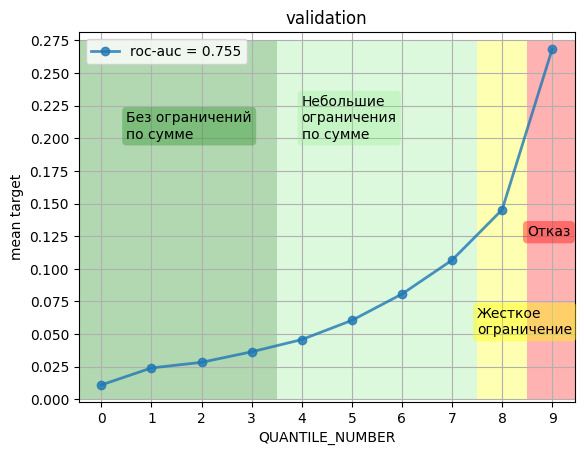

In [41]:
import matplotlib.patches as patches
score = roc_auc_score(X_valid['target'], X_valid['PROBA'])
ax = sort_table['target'].plot(
    xticks=np.arange(10),
    marker='o',
    lw=2,
    alpha=0.8,
    grid=True,
    title='validation',
    ylabel='mean target',
    label=f'roc-auc = {score:.3f}',
)
ax.set_yticks(np.arange(0, 0.30, 0.025))
ax.legend()
ax.add_patch(patches.Rectangle((-0.5, 0), 4, 0.275, linewidth=0, facecolor='green', alpha=0.3))
ax.add_patch(patches.Rectangle((3.5, 0), 4, 0.275, linewidth=0, facecolor='lightgreen', alpha=0.3))
ax.add_patch(patches.Rectangle((7.5, 0), 1, 0.275, linewidth=0, facecolor='yellow', alpha=0.3))
ax.add_patch(patches.Rectangle((8.5, 0), 1, 0.275, linewidth=0, facecolor='red', alpha=0.3))

ax.text(0.5, 0.2, 'Без ограничений\nпо сумме', color='k', bbox=dict(facecolor='green', lw=0, alpha=0.3, boxstyle='round, pad=0.3'))
ax.text(4, 0.2, 'Небольшие\nограничения\nпо сумме', color='k', bbox=dict(facecolor='lightgreen', lw=0, alpha=0.3, boxstyle='round, pad=0.3'))
ax.text(7.5, 0.05, 'Жесткое\nограничение', color='k', bbox=dict(facecolor='yellow', lw=0, alpha=0.4, boxstyle='round, pad=0.3'))
ax.text(8.5, 0.125, 'Отказ', color='k', bbox=dict(facecolor='red', lw=0, alpha=0.4, boxstyle='round, pad=0.3'))

In [131]:
def load_and_merge_data():
    print("Загрузка и объединение данных...")
    
    bureau_balance = pd.read_csv(r"C:\Users\Denis\Desktop\ds\credit_scoring\data\features\features_bureau_balance.csv").fillna(0)#.drop('overdue_ratio', axis=1).fillna(0)
    bureau = pd.read_csv(r"C:\Users\Denis\Desktop\ds\credit_scoring\data\features\features_bureau.csv").fillna(0)
    bureau_aggregated = bureau.groupby('sk_id_curr').median().reset_index()
    bureau_aggregated = bureau_aggregated.drop('sk_bureau_id', axis=1)
    credit_card_balance = pd.read_csv(r"C:\Users\Denis\Desktop\ds\credit_scoring\data\features\features_credit_card_balance.csv").fillna(0)
    installments_payments = pd.read_csv(r"C:\Users\Denis\Desktop\ds\credit_scoring\data\features\features_installments_payments.csv").fillna(0)
    previous_application = pd.read_csv(r"C:\Users\Denis\Desktop\ds\credit_scoring\data\features\features_previous_application.csv").fillna(0)
    df = pd.read_csv(r"C:\Users\Denis\Desktop\ds\credit_scoring\data\features\features_application_train_test.csv")
    
    test = df[df['target'].isnull()]
    train = df.drop(test.index)

    missing_percentage = train.isnull().sum() / len(train) * 100
    columns_to_keep = missing_percentage[missing_percentage <= 15].index
    train = train[columns_to_keep].fillna(0)
    test = test[columns_to_keep].fillna(0)

    train = train.merge(bureau_balance, on='sk_id_curr', how='left')
    train = train.merge(bureau_aggregated, on='sk_id_curr', how='left')
    train = train.merge(credit_card_balance, on='sk_id_curr', how='left')
    train = train.merge(installments_payments, on='sk_id_curr', how='left')
    train = train.merge(previous_application, on='sk_id_curr', how='left')

    test = test.merge(bureau_balance, on='sk_id_curr', how='left')
    test = test.merge(bureau_aggregated, on='sk_id_curr', how='left')
    test = test.merge(credit_card_balance, on='sk_id_curr', how='left')
    test = test.merge(installments_payments, on='sk_id_curr', how='left')
    test = test.merge(previous_application, on='sk_id_curr', how='left')


    train.replace([-np.inf, np.inf], np.nan, inplace=True)
    train.fillna(0, inplace=True)
    test.replace([-np.inf, np.inf], np.nan, inplace=True)
    test.fillna(0, inplace=True)


    train = train.fillna(-1)
    test['target'] = test['target'].fillna(999)
    test = test.fillna(-1)
    test['target'] = test['target'].replace(999, np.nan)

    return train, test

def build_preprocessing_pipeline(X):
    binary_cols = []
    for col in X.select_dtypes(include=[np.number]).columns:
        unique_vals = X[col].dropna().unique()
        if len(unique_vals) == 2 and set(unique_vals).issubset({0, 1}):
            binary_cols.append(col)
    binary_cols = [col for col in binary_cols if col != "document_sum"]

    cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
    num_cols = X.select_dtypes(include=[np.number]).columns.difference(binary_cols).tolist()
    num_cols = [col for col in num_cols if col != "sk_id_curr"]
    X[cat_cols] = X[cat_cols].astype(str)

    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), cat_cols),
        ("bin", StandardScaler(), binary_cols)
    ], remainder='passthrough')

    return preprocessor

def preprocess_data(train):
    print("Предобработка данных...")
    X = train.drop(['target'], axis=1)
    y = train['target'].astype(int)
    sk_id_curr = X['sk_id_curr']  # Сохранение sk_id_curr
    X = X.drop('sk_id_curr', axis=1)  # Удаляем sk_id_curr из X для предобработки
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)
    
    for df_ in [X_train, X_valid]:
        df_[["flag_own_car", "flag_own_realty"]] = df_[["flag_own_car", "flag_own_realty"]].replace({'Y': 1, 'N': 0})
        #df_["flag_mobil"] = df_["flag_mobil"].astype(int)


    preprocessor = build_preprocessing_pipeline(X_train)

    X_train_processed = preprocessor.fit_transform(X_train)
    X_valid_processed = preprocessor.transform(X_valid)
    

    feature_names = preprocessor.get_feature_names_out()
    X_train_df = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
    X_valid_df = pd.DataFrame(X_valid_processed, columns=feature_names, index=X_valid.index)
    

    X_train_df['sk_id_curr'] = sk_id_curr[X_train.index]
    X_valid_df['sk_id_curr'] = sk_id_curr[X_valid.index]
    return X_train_df, X_valid_df, y_train, y_valid

In [44]:
with open(model_path, 'rb') as file:
    model_1 = pickle.load(file)

# Теперь модель загружена и готова к использованию
print("Модель успешно загружена!")

Модель успешно загружена!


In [132]:
RANDOM_STATE = 42
train_1, test_1 = load_and_merge_data()
X_train_1, X_valid_1, y_train_1, y_valid_1 = preprocess_data(train_1)
X_train_1.columns = X_train_1.columns.str.replace(r'[^\w\d_]+', '_', regex=True)
X_valid_1.columns = X_valid_1.columns.str.replace(r'[^\w\d_]+', '_', regex=True)
X_train_1 = X_train_1.loc[:, ~X_train_1.columns.duplicated()]
X_valid_1 = X_valid_1.loc[:, ~X_valid_1.columns.duplicated()]

Загрузка и объединение данных...
Предобработка данных...


C:\Users\Denis\AppData\Local\Temp\ipykernel_7604\2899928243.py:77: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_[["flag_own_car", "flag_own_realty"]] = df_[["flag_own_car", "flag_own_realty"]].replace({'Y': 1, 'N': 0})
C:\Users\Denis\AppData\Local\Temp\ipykernel_7604\2899928243.py:77: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_[["flag_own_car", "flag_own_realty"]] = df_[["flag_own_car", "flag_own_realty"]].replace({'Y': 1, 'N': 0})


In [46]:
print("Сохранение SHAP важностей...")
combined_shap_1 = pd.DataFrame(index=X_train_1.columns)
model_1.fit(X_train_1, y_train_1)
explainer_1 =  shap.Explainer(model_1)
shap_values_1 = explainer_1.shap_values(X_valid_1)
shap_importance_1 = pd.Series(np.abs(shap_values_1).mean(axis=0), index=X_train_1.columns)
combined_shap_1['feature'] = X_train_1.columns
combined_shap_1['mean_importance'] = shap_importance_1.values
combined_shap_1 = combined_shap_1.sort_values(by='mean_importance', ascending=False).head(80).index

Сохранение SHAP важностей...
[LightGBM] [Info] Number of positive: 18619, number of negative: 212012
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,592491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33456
[LightGBM] [Info] Number of data points in the train set: 230631, number of used features: 267
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,080731 -> initscore=-2,432460
[LightGBM] [Info] Start training from score -2,432460


c:\Users\Denis\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [133]:
X_train_1 = X_train_1[['sk_id_curr', *combined_shap_1]]
X_valid_1 = X_valid_1[['sk_id_curr', *combined_shap_1]]
X_train_2, X_valid_2, y_train_2, y_valid_2 = preprocess_data(test_1)
X_train_2.columns = X_train_2.columns.str.replace(r'[^\w\d_]+', '_', regex=True)
X_valid_2.columns = X_valid_2.columns.str.replace(r'[^\w\d_]+', '_', regex=True)
test = pd.concat([X_train_2, X_valid_2], axis=0, ignore_index=True)
test = test[['sk_id_curr', *combined_shap_1]]



Предобработка данных...


C:\Users\Denis\AppData\Local\Temp\ipykernel_7604\2899928243.py:77: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_[["flag_own_car", "flag_own_realty"]] = df_[["flag_own_car", "flag_own_realty"]].replace({'Y': 1, 'N': 0})
C:\Users\Denis\AppData\Local\Temp\ipykernel_7604\2899928243.py:77: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_[["flag_own_car", "flag_own_realty"]] = df_[["flag_own_car", "flag_own_realty"]].replace({'Y': 1, 'N': 0})


In [129]:
X_train_1.head(5)

,sk_id_curr,sk_id_curr,num__weighted_score,num__prev_app_credit_to_application_ratio_mean,num__instal_total_payment,num__group_mean_income,num__annuity_credit_ratio,num__ext_source_2,num__instal_std_amt_payment,num__credit_minus_goods,...,num__bb_last_active_interval,num__amt_credit_limit_actual_mean_recent_6,num__amt_credit_limit_actual_min_recent_6,num__avg_income_per_child,num__amt_balance_max_recent_6,cat__weekday_appr_process_start_SATURDAY,num__amt_credit_limit_actual_sum_recent_12,num__amt_balance_mean_recent_12,num__payment_minus_drawings,num__payment_balance_ratio
126362,246794,246794,1.054048,0.154538,-0.562143,0.740362,-0.842875,-0.008917,-0.513697,-0.861649,...,0.2058,-0.370695,-0.355824,-0.493882,-0.265836,0.0,-0.356906,-0.25794,0.226055,-0.011334
137407,259566,259566,-0.430459,-1.067418,-0.514851,0.257075,0.309927,-0.506320,-0.427079,0.141279,...,0.2058,-0.370695,-0.355824,-0.493882,-0.265836,0.0,-0.356906,-0.25794,0.226055,-0.011334
150746,274952,274952,0.202393,-0.004230,-0.583423,2.546833,-0.165032,0.429930,-0.304813,-0.861649,...,0.2058,-0.370695,-0.355824,-0.493882,-0.265836,0.0,-0.356906,-0.25794,0.226055,-0.011334
215301,349640,349640,0.204702,0.187083,0.376101,0.257075,0.598796,-0.079986,1.038982,-0.360185,...,0.2058,3.613912,3.705780,0.153985,-0.265836,0.0,4.015896,-0.25794,0.226055,-0.011334
93585,208875,208875,0.483392,0.265512,-0.048057,-0.831802,-0.914825,0.557082,0.688995,2.648599,...,0.2058,-0.370695,-0.355824,-0.493882,-0.265836,0.0,-0.356906,-0.25794,0.226055,-0.011334


In [130]:
test_1.head(5)

,sk_id_curr,document_sum,flag_full_info_house,year_birth,years_since_id_change,id_change_years,document_change_delay,income_annuity_ratio,avg_count_children_per_adult,avg_income_per_child,...,prev_app_count,prev_app_approved_ratio,prev_app_mean_amt_credit,prev_app_credit_to_application_ratio_mean,prev_app_mean_dpd,prev_app_cash_loan_ratio,prev_app_median_goods_price,prev_app_last_app_days,prev_app_down_payment_rate_mean,prev_app_most_common_weekday
0,121296,1,1,26,6,20,0,0.882566,0.0,0.0,...,9.0,0.555556,105022.500000,0.978647,-583.555556,0.555556,67227.75,-2402.0,0.129881,FRIDAY
1,121300,1,1,39,14,25,1,2.387400,0.5,90000.0,...,3.0,1.000000,75382.500000,1.003820,-1032.000000,0.000000,76815.00,-2412.0,0.088482,WEDNESDAY
2,121308,1,1,37,7,30,1,2.323200,0.5,56250.0,...,6.0,0.500000,197283.750000,0.998666,-917.333333,0.333333,294745.50,-2724.0,0.060631,MONDAY
3,121321,1,1,51,6,45,0,2.366400,0.0,0.0,...,3.0,1.000000,331927.500000,0.825137,-1531.333333,0.000000,261000.00,-2505.0,0.190442,FRIDAY
4,121323,1,1,62,11,51,1,2.247750,0.0,0.0,...,13.0,0.692308,144620.653846,0.968957,-700.923077,0.384615,167400.00,-1736.0,0.050392,FRIDAY


In [ ]:
#model_1.fit(X_train_1.drop('sk_id_curr',axis=1), y_train_1)
X_valid_1['PROBA_advanced'] = model_1.predict_proba(X_valid_1.drop('sk_id_curr',axis=1))[:, 1]
X_valid_1['target'] = y_valid_1

X_valid_1['QUANTILE_advanced'] = pd.qcut(
    X_valid_1['PROBA_advanced'],
    q=10,
)
X_valid_1['QUANTILE_N_advanced'] = pd.qcut(
    X_valid_1['PROBA_advanced'],
    q=10,
    labels=np.arange(10),
)




In [135]:
X_train_1 = X_train_1.loc[:, ~X_train_1.columns.duplicated()]
X_valid_1 = X_valid_1.loc[:, ~X_valid_1.columns.duplicated()]

In [58]:
result.head(5)

,sk_id_curr,document_sum,flag_full_info_house,year_birth,years_since_id_change,id_change_years,document_change_delay,income_annuity_ratio,avg_count_children_per_adult,avg_income_per_child,...,bb_share_dpd_4,bb_share_dpd_5,bb_last_closed_interval,bb_last_active_interval,PROBA,QUANTILE,QUANTILE_NUMBER,PROBA_advanced,QUANTILE_advanced,QUANTILE_N_advanced
0,100281,1,0,49,4,45,0,2.336640,0.500000,112500.0,...,-1.0,-1.0,-1.0,-1.0,0.280713,"(0.234, 0.289]",3,0.233311,"(0.208, 0.265]",3
1,100285,0,1,29,9,20,0,0.960000,0.000000,0.0,...,-1.0,-1.0,-1.0,-1.0,0.596832,"(0.58, 0.684]",8,0.641035,"(0.576, 0.688]",8
2,100290,1,1,40,7,33,1,1.574000,0.000000,0.0,...,-1.0,-1.0,-1.0,-1.0,0.814492,"(0.684, 0.922]",9,0.783245,"(0.688, 0.939]",9
3,100291,1,1,32,12,20,0,1.125882,0.333333,153000.0,...,0.0,0.0,0.0,0.0,0.764631,"(0.684, 0.922]",9,0.656964,"(0.576, 0.688]",8
4,100294,1,1,57,10,47,1,2.696571,0.000000,0.0,...,0.0,0.0,-59.0,0.0,0.285243,"(0.234, 0.289]",3,0.451539,"(0.401, 0.482]",6


In [69]:
features_1

,0
0,num__weighted_score
1,num__prev_app_credit_to_application_ratio_mean
2,num__instal_total_payment
3,num__group_mean_income
4,num__annuity_credit_ratio
...,...
75,cat__weekday_appr_process_start_SATURDAY
76,num__amt_credit_limit_actual_sum_recent_12
77,num__amt_balance_mean_recent_12
78,num__payment_minus_drawings


In [70]:
#selected_rows_1 = train_1[train_1['sk_id_curr'].isin(X_valid_1['sk_id_curr'])]
#result = result.merge(X_valid_1[['sk_id_curr', 'PROBA_advanced', 'QUANTILE_advanced', 'QUANTILE_N_advanced']], on='sk_id_curr', how='left')
features_1 = combined_shap_1.drop('sk_id_curr', errors='ignore').to_frame()
#features_1 = pd.Series(combined_shap_1).to_frame()
features_1['importance'] = model_1.feature_importances_
print(features_1)

                                                                                             0  \
num__weighted_score                                                        num__weighted_score   
num__prev_app_credit_to_application_ratio_mean  num__prev_app_credit_to_application_ratio_mean   
num__instal_total_payment                                            num__instal_total_payment   
num__group_mean_income                                                  num__group_mean_income   
num__annuity_credit_ratio                                            num__annuity_credit_ratio   
...                                                                                        ...   
cat__weekday_appr_process_start_SATURDAY              cat__weekday_appr_process_start_SATURDAY   
num__amt_credit_limit_actual_sum_recent_12          num__amt_credit_limit_actual_sum_recent_12   
num__amt_balance_mean_recent_12                                num__amt_balance_mean_recent_12   
num__payment_minus_d

In [136]:


sort_table_advanced = result.groupby([
    'QUANTILE_N_advanced',
]).agg(
    count=pd.NamedAgg(column='sk_id_curr', aggfunc='count'),
    target=pd.NamedAgg(column='target', aggfunc='mean'),
    credit_vs_income_ratio=pd.NamedAgg(column='credit_vs_income_ratio', aggfunc='mean'),
    mean_weighted_score=pd.NamedAgg(column='weighted_score', aggfunc='mean'),
    mean_group_mean_income=pd.NamedAgg(column='group_mean_income', aggfunc='mean'),
    years_birth=pd.NamedAgg(column='year_birth', aggfunc='mean'),
    num__ext_source_2_median=pd.NamedAgg(column='ext_source_2', aggfunc='median'),
    mean_total_credits=pd.NamedAgg(column='total_credits', aggfunc='mean'),
    disposable_income=pd.NamedAgg(column='disposable_income', aggfunc='mean'),
)

(
    sort_table_advanced
    .style
    .format('{:,.2f}', subset=['credit_vs_income_ratio', 'num__ext_source_2_median', 'disposable_income'])
    .format('{:.0f} years', subset=['years_birth'])
    .background_gradient(axis=0, vmin=0, vmax=0.22, gmap=sort_table['target'], cmap="coolwarm")
)

C:\Users\Denis\AppData\Local\Temp\ipykernel_7604\3671602338.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sort_table_advanced = result.groupby([


,count,target,credit_vs_income_ratio,mean_weighted_score,mean_group_mean_income,years_birth,num__ext_source_2_median,mean_total_credits,disposable_income
QUANTILE_N_advanced,,,,,,,,,
0,7688,0.009365,3.36,1.304433,173914.030008,48 years,0.68,0.938476,"162,194.25"
1,7688,0.016649,3.97,1.193592,170130.571986,47 years,0.65,0.974506,"149,343.19"
2,7688,0.029006,4.15,1.132402,169593.544632,46 years,0.63,1.044485,"145,181.45"
3,7687,0.030961,4.30,1.063832,168951.130633,46 years,0.61,1.079615,"144,432.57"
4,7688,0.044225,4.24,0.988273,168165.259973,45 years,0.58,1.016519,"142,811.74"
5,7688,0.056712,4.14,0.921492,168483.068990,44 years,0.55,1.056582,"140,377.99"
6,7687,0.075972,4.09,0.851317,167269.639950,42 years,0.52,0.960973,"138,768.73"
7,7688,0.102497,3.99,0.766457,166723.438377,41 years,0.48,1.087539,"133,645.75"
8,7688,0.156608,3.78,0.672770,166978.117544,39 years,0.41,1.071280,"132,950.00"


Text(8.5, 0.125, 'Отказ')

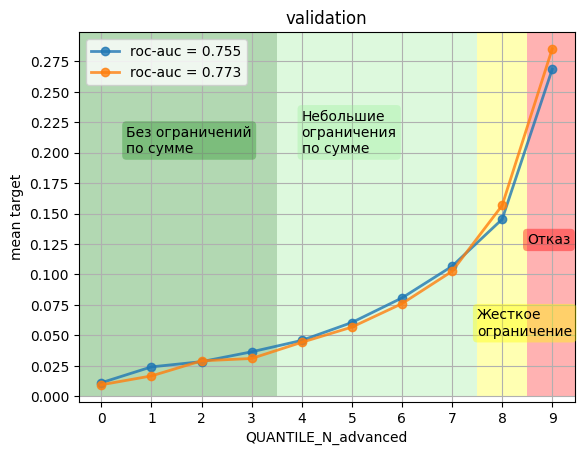

In [74]:
score = roc_auc_score(X_valid['target'], X_valid['PROBA'])
ax = sort_table['target'].plot(
    xticks=np.arange(10),
    marker='o',
    lw=2,
    alpha=0.8,
    grid=True,
    title='validation',
    ylabel='mean target',
    label=f'roc-auc = {score:.3f}',
)
score_1 = roc_auc_score(X_valid_1['target'], X_valid_1['PROBA_advanced'])
ax = sort_table_advanced['target'].plot(
    xticks=np.arange(10),
    marker='o',
    lw=2,
    alpha=0.8,
    grid=True,
    title='validation',
    ylabel='mean target',
    label=f'roc-auc = {score_1:.3f}',
)
ax.set_yticks(np.arange(0, 0.30, 0.025))
ax.legend()
ax.add_patch(patches.Rectangle((-0.5, 0), 4, 0.3, linewidth=0, facecolor='green', alpha=0.3))
ax.add_patch(patches.Rectangle((3.5, 0), 4, 0.3, linewidth=0, facecolor='lightgreen', alpha=0.3))
ax.add_patch(patches.Rectangle((7.5, 0), 1, 0.3, linewidth=0, facecolor='yellow', alpha=0.3))
ax.add_patch(patches.Rectangle((8.5, 0), 1, 0.3, linewidth=0, facecolor='red', alpha=0.3))

ax.text(0.5, 0.2, 'Без ограничений\nпо сумме', color='k', bbox=dict(facecolor='green', lw=0, alpha=0.3, boxstyle='round, pad=0.3'))
ax.text(4, 0.2, 'Небольшие\nограничения\nпо сумме', color='k', bbox=dict(facecolor='lightgreen', lw=0, alpha=0.3, boxstyle='round, pad=0.3'))
ax.text(7.5, 0.05, 'Жесткое\nограничение', color='k', bbox=dict(facecolor='yellow', lw=0, alpha=0.4, boxstyle='round, pad=0.3'))
ax.text(8.5, 0.125, 'Отказ', color='k', bbox=dict(facecolor='red', lw=0, alpha=0.4, boxstyle='round, pad=0.3'))



In [137]:
transitions = result.groupby([
    'QUANTILE_NUMBER',
    'QUANTILE_N_advanced',
])['sk_id_curr'].count().unstack()

(
    transitions
    .style
    .background_gradient(axis=None, cmap='Blues')
)

C:\Users\Denis\AppData\Local\Temp\ipykernel_7604\3398912373.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  transitions = result.groupby([


QUANTILE_N_advanced,0,1,2,3,4,5,6,7,8,9
QUANTILE_NUMBER,,,,,,,,,,
0,4982,1807,621,193,68,14,3,0,0,0
1,1841,2609,1799,892,368,135,35,9,0,0
2,599,1790,2103,1657,918,425,154,39,3,0
3,175,880,1626,1865,1579,992,404,144,21,1
4,68,414,916,1577,1799,1564,929,341,76,4
5,20,136,436,924,1510,1854,1657,895,235,21
6,3,44,150,430,936,1542,1953,1785,738,106
7,0,8,34,124,421,894,1643,2276,1880,408
8,0,0,3,25,84,249,819,1777,3088,1643


In [123]:
result.shape

(76878, 88)

In [77]:
(
    transitions
    .div(transitions.sum(axis=1), axis=0)
    .mul(100)
    .style
    .format('{:.0f}%')
    .background_gradient(axis=None, cmap='Blues')
)

QUANTILE_N_advanced,0,1,2,3,4,5,6,7,8,9
QUANTILE_NUMBER,,,,,,,,,,
0,65%,24%,8%,3%,1%,0%,0%,0%,0%,0%
1,24%,34%,23%,12%,5%,2%,0%,0%,0%,0%
2,8%,23%,27%,22%,12%,6%,2%,1%,0%,0%
3,2%,11%,21%,24%,21%,13%,5%,2%,0%,0%
4,1%,5%,12%,21%,23%,20%,12%,4%,1%,0%
5,0%,2%,6%,12%,20%,24%,22%,12%,3%,0%
6,0%,1%,2%,6%,12%,20%,25%,23%,10%,1%
7,0%,0%,0%,2%,5%,12%,21%,30%,24%,5%
8,0%,0%,0%,0%,1%,3%,11%,23%,40%,21%



## 1. Изменение средних показателей по квантилям
#### target: в «низком» квантиле он опустился (0.011→ 0.009), а в «высоком» вырос (0.268→ 0.285).

####  credit_vs_income_ratio почти не изменился, но mean_weighted_score сместился: низкие квантиля получили чуть более высокие скор‑оценки.

#### median ext_source_2 и доход по-прежнему чётко отличаются: низшие квантиля имеют более высокий ext_source_2, более высокий доход и больший возраст.

#### Вывод: модель стала ещё чуть более чувствительной к разным сегментам риска, усилив контраст «хороших» и «плохих» клиентов.

## 2. Кросс‑таблица «старых» vs «новых» квантилей

#### Диагональ (где old=new) — от 65% в квантиле 0 до 72% в квантиле 9.

#### Смещения:

#### Из старого 0‑го квантиля 24% перешло в новый 1‑й, но почти никто не поднялся сразу в высокие квантиля.

#### Из старого 9‑го квантиля 21% перешло в новый 8‑й, 5% в 7‑й, но 72% остались в 9‑м — значит, модель старая «расплывалась» сильнее.

#### Улучшение дисперсии: новые квантиля «скошены» сильнее к диагонали → меньше «размывания» между отдалёнными квантилями.

# Итоговая оценка
#### Модель стала более «резкой»:
##### – Клиенты теперь чаще остаются в том же квантиле или переходят на соседний, а не на отдалённые.

#### Улучшена сегментация риска:
##### – Верхний квантиль новых предсказаний (9) содержит более концентрированно «плохих» клиентов (target≈0.29).

##### – Нижний квантиль новых предсказаний (0) стал ещё «чище» (target≈0.009).

#### Стабильность:
##### – Диагональ кросс‑таблицы выросла (с ~60–65% до ~65–72%) — меньше «шумных» попаданий не на свои квантиля.

## Вывод: «продвинутые» вероятности (PROBA_advanced) дают лучшее ранжирование клиентов по риску — сегменты стали более чистыми и однородными.

In [151]:
ids.sort_values

<bound method Series.sort_values of 0         100277
1         100279
2         100281
3         100282
4         100283
           ...  
307504    100273
307505    100274
307506    100275
307507    100276
307508    114949
Name: sk_id_curr, Length: 307509, dtype: int64>

In [ ]:
ids = train['sk_id_curr']

result['DAY_OF_YEAR'] = ((ids - ids.min()) / (ids.max() - ids.min()) * 365 + 1).astype(int)
result['DATE_OF_APPLICATION'] = pd.to_datetime(2023 * 1000 + result['DAY_OF_YEAR'], format='%Y%j')
result['IS_TRAINING'] = False
#result.loc[
#    result['DATE_OF_APPLICATION'].le('2023-09-01')
 #   & result['target'].notna(),
#    'IS_TRAINING'
#] = True



#application.loc[application['TARGET'].isna(), 'group'] = 'test'
#result.loc[result['target'].notna() & result['IS_TRAINING'].eq(False), 'group'] = 'validation'

C:\Users\Denis\AppData\Local\Temp\ipykernel_7604\576352265.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([


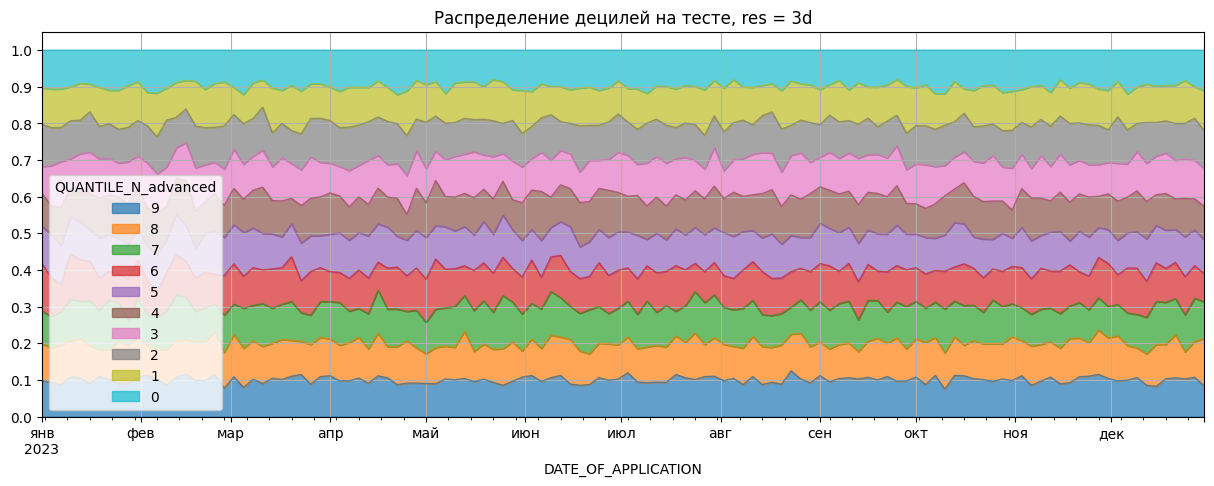

In [ ]:
res = result.copy()

# 2) Отсортируй по sk_id_curr
res = res.sort_values('sk_id_curr').reset_index(drop=True)

# 3) Теперь выдерни идентификаторы
ids_sorted = res['sk_id_curr']

# 4) Преобразуй в номер дня правильно
res['DAY_OF_YEAR'] = (
    (ids_sorted - ids_sorted.min()) 
    / (ids_sorted.max() - ids_sorted.min()) 
    * 365 + 1
).astype(int)

# 5) Построй дату на 2023 год
res['DATE_OF_APPLICATION'] = pd.to_datetime(
    2023*1000 + res['DAY_OF_YEAR'], 
    format='%Y%j'
)

# 6) Группировка
info = (
    res
    .groupby([
        pd.Grouper(key='DATE_OF_APPLICATION', freq='3d'),
        'QUANTILE_N_advanced'
    ])['sk_id_curr']
    .count()
    .unstack(fill_value=0)
)

# 7) Нормировка и реверс колонок
info = info.reindex(sorted(info.columns, reverse=True), axis=1)
info = info.div(info.sum(axis=1), axis=0)

# 8) Отрисовка
ax = info.plot.area(
    figsize=(15, 5),
    grid=True,
    alpha=0.7,
    lw=1,
    yticks=np.linspace(0, 1, 11),
    title='Распределение децилей на тесте, res = 3d'
)

**Вывод**: мы наблюдаем ровное распределение ~10% в каждой из квантили - это хороший показатель того, что тестовая выборка соответствует валидации, и мы можем смело деплоить модель на такой поток данных.